In [24]:
%matplotlib widget
from pathlib import Path

import numpy as np
import scipy.signal as sps

from spectrometer import FID1D, process
from spectrometer.process import decaying_sinus

cm = 1 / 2.54

In [25]:
# Load raw *.fid data
file = Path(
    "../data/20230822-091753-Water-1H-single_90_degree_pulse,length=9us,delay=25us,record_length=10000,sample_rate=320000,probe=andrew.fid"
)
fid = FID1D.from_file(file)

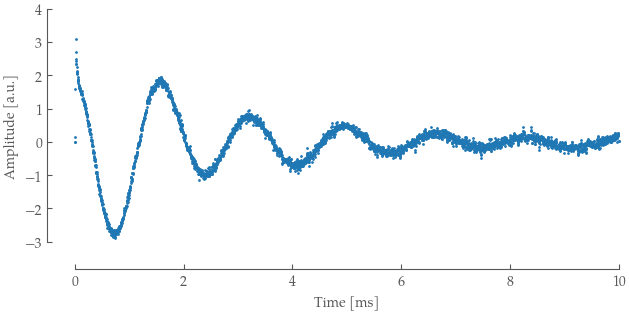

In [26]:
# Plot raw data
fig = fid.plot(
    figsize=(16.0 * cm, 8.0 * cm)  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
fig.savefig("fid_raw.pdf")

/home/max/Projects/nmr-spectrometer/software/spectrometer/spectrometer/plot.py:127: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(


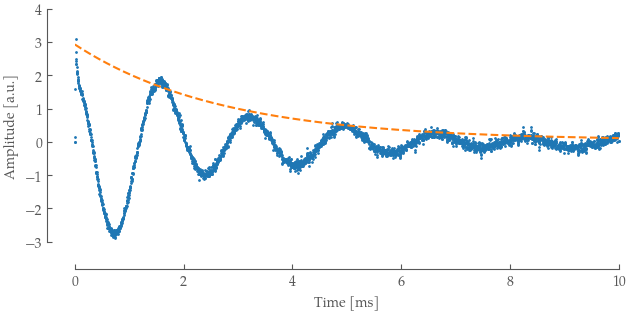

In [27]:
# Try fitting the envelope
try:
    # Plot raw data
    fig = fid.plot(
        figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
    )
    axes = fig.axes[0]

    envelope = np.abs(sps.hilbert(fid.real))
    fit_exp_decay = process.exp_decay.fit(fid.ms_scale, envelope)
    ms_scale_fine = np.linspace(
        fid.ms_scale[0], fid.ms_scale[-1], len(fid.ms_scale) * 10
    )
    axes.plot(
        ms_scale_fine,
        fit_exp_decay(ms_scale_fine),
        linestyle="--",
    )

    # Try fitting the absolute directly
    fit_abs = process.exp_decay.fit(fid.ms_scale, fid.absolute)
    axes.plot(
        ms_scale_fine,
        fit_abs(ms_scale_fine),
        linestyle=":",
    )
except RuntimeError:
    pass

fig.savefig("fid_envelope_fit.pdf")

Amplitude: 3.1706557340566004
Frequency: 0.5892140431027253
Phase: 2.02247888878803
Offset: -0.020663079016846702
Lambda: 0.3928068920346734
T2*: 2.545780179212663 ms


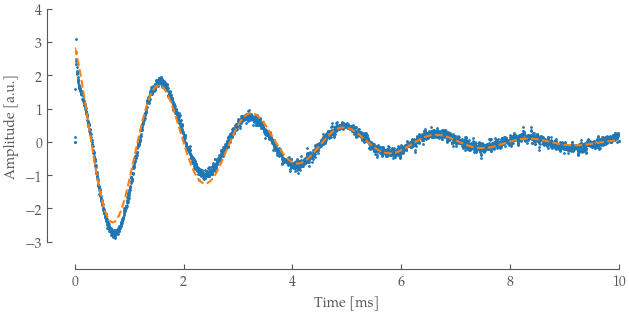

In [28]:
# Try to plot simple least squares fit for a decaying sinusoid
decaying_sinus_fit = decaying_sinus.fit(fid.ms_scale, fid.real)
ms_scale_fine = np.linspace(fid.ms_scale[0], fid.ms_scale[-1], len(fid.ms_scale) * 10)
print(decaying_sinus_fit)
print(f"T2*: {1/decaying_sinus_fit.lambda_} ms")

# Plot raw
fig = fid.plot(figsize=(16 * cm, 8 * cm))  # Wide Layout: ~16cm, Margin Layout: 10.7cm

# Plot fit
fig.axes[0].plot(
    ms_scale_fine,
    decaying_sinus_fit(ms_scale_fine),
    linestyle="--",
)

fig.savefig("fid_sine_fit.pdf")

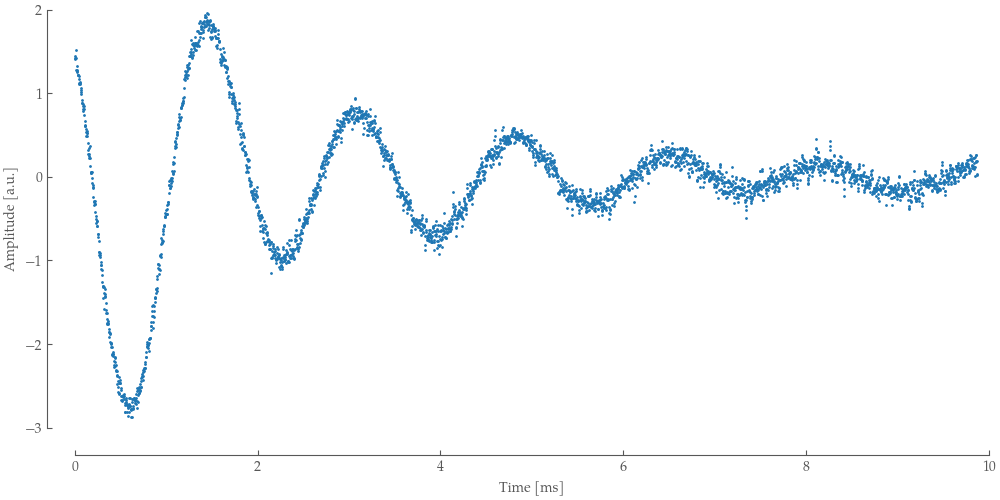

In [29]:
# Crop first points
# They lead to sinc shaped peaks due to the transient response of the CIC filter
# See Protein NMR Spectroscopy 3.3.2, Figure 3.14, p. 157 for more details
fid.data = fid[40:]
fig = fid.plot()

Phase Shift: 62.6941875000001


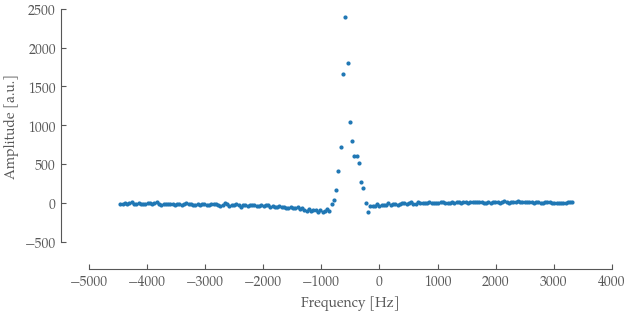

In [30]:
# Spectrum
spectrum, p0 = fid.spectrum()
print(f"Phase Shift: {p0}")

peak_spectrum = spectrum.crop_around(spectrum.max_peak, 200)
peak_fig = peak_spectrum.hz.plot(figsize=(16 * cm, 8 * cm))

peak_fig.savefig("fft_raw.pdf")

Amplitude: 2396.474629930545
Gamma: 63.13884011180165 Hz
Full Width at Half Maximum: 126.2776802236033 Hz
T2* is thus: 2.52071376050107 ms
Position: -577.5374144017011 Hz
Amplitude: 2396.474629930545
Noise: 9.6381254196167
SNR: 248.64530451667963

-------- Estimation for 2.5Hz FWHM -------
Gamma: 1.25
Amplitude: 121048.50279293896
SNR 12559.340901143094


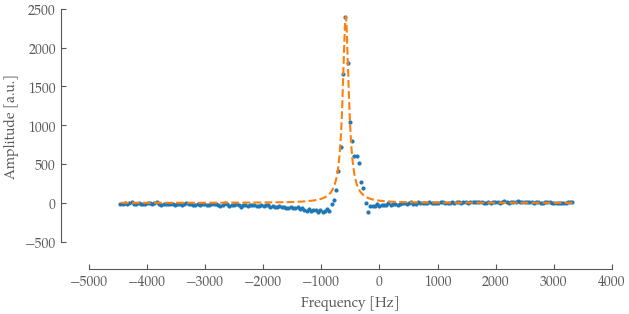

In [31]:
lorentz = peak_spectrum.hz.fit_lorentz()
hz_scale_fine = np.linspace(
    peak_spectrum.hz.limits[0], peak_spectrum.hz.limits[1], peak_spectrum.hz.size * 10
)

fig = peak_spectrum.hz.plot(figsize=(16 * cm, 8 * cm))
fig.axes[0].plot(hz_scale_fine, lorentz(hz_scale_fine), linestyle="--")

print(f"Amplitude: {lorentz.amplitude}")
print(f"Gamma: {lorentz.gamma} Hz")
print(f"Full Width at Half Maximum: {lorentz.fwhm} Hz")
print(f"T2* is thus: {1000/(np.pi * lorentz.fwhm)} ms")
print(f"Position: {lorentz.position} Hz")

# Estimate SNR
noise = spectrum.hz.noise(1000, 2000)
snr = lorentz.amplitude / noise
print(f"Amplitude: {lorentz.amplitude}")
print(f"Noise: {noise}")
print(f"SNR: {snr}")

# Assuming we can get to 2.5Hz (0.1ppm) linewidth (FWHM)
f = lorentz.fwhm / 2.5
print(f"\n-------- Estimation for 2.5Hz FWHM -------")
print(f"Gamma: {lorentz.gamma/f}")
print(f"Amplitude: {lorentz.amplitude * f}")
print(f"SNR {lorentz.amplitude * f / noise}")

fig.savefig("fft_fit.pdf")

[Peak(location=-546.8749999999991, amplitude=2421.0699307610967, fwhm=121.21389304651609, signal_strength=5862.46728515625, other_parameters=())]


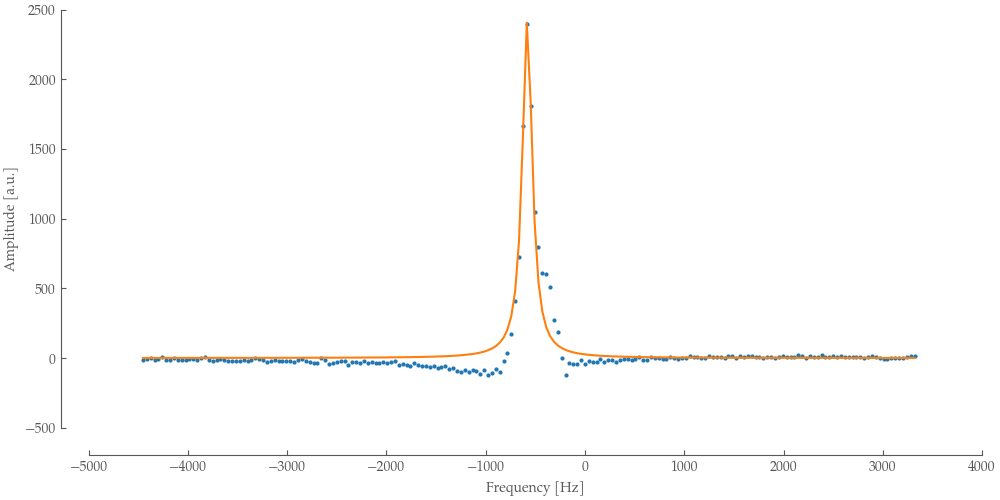

In [32]:
peaks = peak_spectrum.ppm.peaks()
fitted_spectrum, peaks = peak_spectrum.hz.fit()

fig = peak_spectrum.hz.plot()
fig.axes[0].plot(peak_spectrum.hz.scale, fitted_spectrum)
print(peaks)